# 1. First model: modeling the stock market time serie without any extra features

1. Importing essential libraries for data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr
%matplotlib inline

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
    
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv(r"C:\Users\yunus\Desktop\tulasi\BP.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/14/2003,42.5600,43.1500,42.5200,42.9000,18.0799,2683900
1,8/15/2003,42.6500,42.6500,42.1400,42.4000,17.8692,1595300
2,8/18/2003,42.4000,42.7700,42.4000,42.7000,17.9956,2383100
3,8/19/2003,43.5400,43.5400,41.8500,42.2300,17.7975,2119800
4,8/20/2003,42.1200,42.5200,42.0300,42.4400,17.8860,1691500


In [4]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
# changing the Date structure from object to 'datetime'

df.Date = pd.to_datetime(df.Date)

In [6]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [7]:
# renaming the column from 'Adj Close' as 'BP'

df.rename({'Adj Close' : 'BP'}, axis = 1, inplace =True)

In [8]:
df.head()

,Date,Open,High,Low,Close,BP,Volume
0,2003-08-14,42.5600,43.1500,42.5200,42.9000,18.0799,2683900
1,2003-08-15,42.6500,42.6500,42.1400,42.4000,17.8692,1595300
2,2003-08-18,42.4000,42.7700,42.4000,42.7000,17.9956,2383100
3,2003-08-19,43.5400,43.5400,41.8500,42.2300,17.7975,2119800
4,2003-08-20,42.1200,42.5200,42.0300,42.4400,17.8860,1691500


In [9]:
# in the final dataframe to predict the british petroleum prices we will use only essential columns

final = df[["Date", "Open", "BP"]].copy()

In [10]:
final.head()

,Date,Open,BP
0,2003-08-14,42.5600,18.0799
1,2003-08-15,42.6500,17.8692
2,2003-08-18,42.4000,17.9956
3,2003-08-19,43.5400,17.7975
4,2003-08-20,42.1200,17.8860


In [11]:
# changing the 'Date' structure to datetime format


final['Date'] = pd.to_datetime(final['Date'], format='%m/%d/%Y')

In [12]:
final.head()

,Date,Open,BP
0,2003-08-14,42.5600,18.0799
1,2003-08-15,42.6500,17.8692
2,2003-08-18,42.4000,17.9956
3,2003-08-19,43.5400,17.7975
4,2003-08-20,42.1200,17.8860


In [13]:
# changing the index to date as the values will be assigned or indexed based upon the Date not on numbers
# this is essential when we are doing the time series processing
# the indexed from Date has been saved in the new dataframe df2.

result = final.sort_values("Date")
result = final.set_index("Date")
result.head()

,Open,BP
Date,,
2003-08-14,42.5600,18.0799
2003-08-15,42.6500,17.8692
2003-08-18,42.4000,17.9956
2003-08-19,43.5400,17.7975
2003-08-20,42.1200,17.8860


In [14]:
result.dtypes

Open    float64
BP      float64
dtype: object

In [15]:

# original time serie (Y)
y = result.BP.values #numpy.ndarray
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)


# extra information: features of the sentiment analysis
X = result.Open.values
X = X.astype('float32')
X = np.reshape(X, (-1, 1))

# training and testing settings (size) based upon 70% to 30%

percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
train_x, test_x = X[0:train_size,:], X[train_size:len(X),:]



def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [16]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)


# calculate extra features in (X)
X_train_features_2, auxiliar_1 = create_dataset(train_x, look_back)
X_test_features_2, auxiliar_2 = create_dataset(test_x, look_back)


# join the all the features in one
## reshape arrays
X_train_features_1 = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features_1  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))
X_train_features_2 = np.reshape(X_train_features_2, (X_train_features_2.shape[0], 1, X_train_features_2.shape[1]))
X_test_features_2  = np.reshape(X_test_features_2, (X_test_features_2.shape[0], 1, X_test_features_2.shape[1]))
## put all together
X_train_all_features = np.append(X_train_features_1,X_train_features_2,axis=1)
X_test_all_features = np.append(X_test_features_1,X_test_features_2,axis=1)


In [17]:
# performing the lstm model onto the dataframe

model = Sequential()
model.add(LSTM(200, input_shape=(X_train_all_features.shape[1], X_train_all_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_all_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_all_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               166400    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_predict = model.predict(X_train_all_features)
test_predict  = model.predict(X_test_all_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.052219886
Train Root Mean Squared Error: 0.059370562
Test Mean Absolute Error: 0.046917852
Test Root Mean Squared Error: 0.05306297


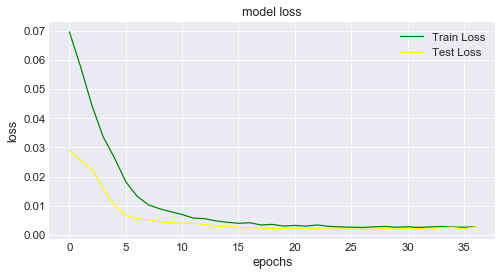

In [19]:
# plotting the figure for testign and training loss

plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

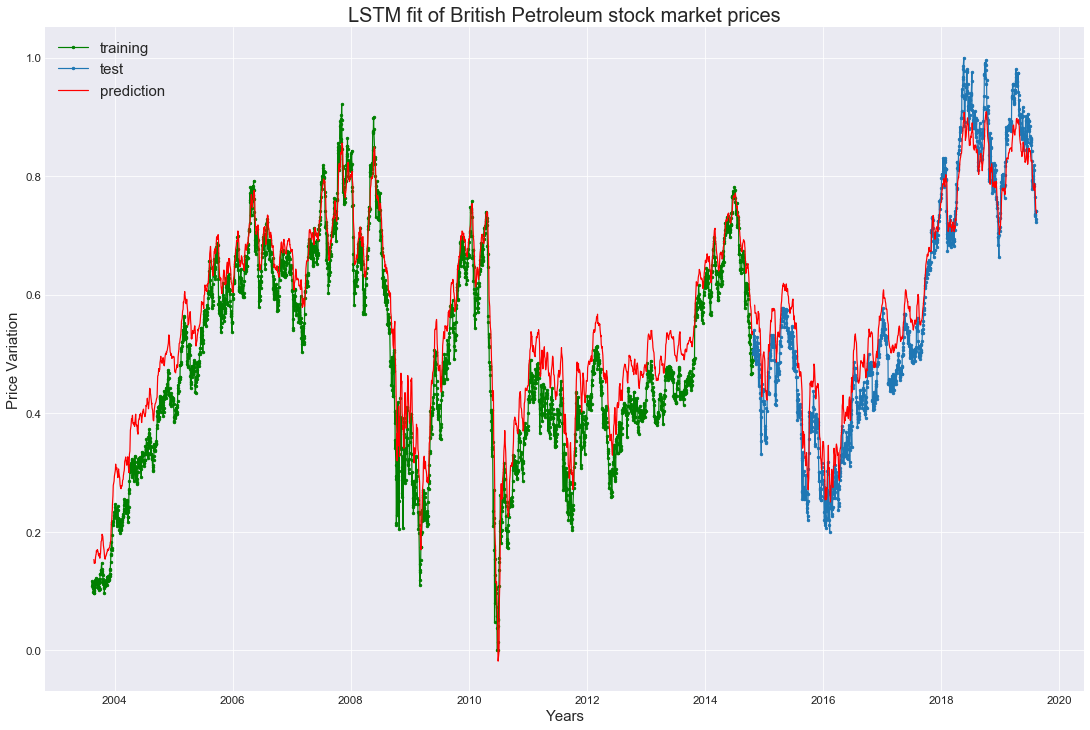

In [20]:
# final prediction based upon the british petroleum dataframe

time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of British Petroleum stock market prices",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('Price Variation', size=15)
plt.xlabel('Years', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

# 2. Second model: modeling the stock market time serie with the sentimen analysis of associated online news as extra features

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [22]:
result2 = pd.read_csv(r"C:\Users\yunus\Desktop\tulasi\final.csv")

In [23]:
result2.head()

,Date,index,compound,BP
0,2003-02-19,0.0000,0.4588,28.3669
1,2003-02-20,7.0000,-0.7351,28.3669
2,2003-02-21,22.0000,0.1531,28.3669
3,2003-02-22,44.0000,-0.4939,28.3669
4,2003-02-23,55.0000,-0.7430,28.3669


In [24]:
result2.dtypes

Date         object
index       float64
compound    float64
BP          float64
dtype: object

In [25]:
# changing the data structure and date format from object to datetime


result2['Date'] = pd.to_datetime(result2['Date'], format='%Y-%m-%d')

In [26]:
result2.head()

,Date,index,compound,BP
0,2003-02-19,0.0000,0.4588,28.3669
1,2003-02-20,7.0000,-0.7351,28.3669
2,2003-02-21,22.0000,0.1531,28.3669
3,2003-02-22,44.0000,-0.4939,28.3669
4,2003-02-23,55.0000,-0.7430,28.3669


In [27]:
# changing the index to date as the values will be assigned or indexed based upon the Date not on numbers
# this is essential when we are doing the time series processing
# the indexed from Date has been saved in the new dataframe df2.


finale = result2.sort_values("Date")
finale = result2.set_index("Date")
finale.head()

,index,compound,BP
Date,,,
2003-02-19,0.0000,0.4588,28.3669
2003-02-20,7.0000,-0.7351,28.3669
2003-02-21,22.0000,0.1531,28.3669
2003-02-22,44.0000,-0.4939,28.3669
2003-02-23,55.0000,-0.7430,28.3669


In [28]:
finale

,index,compound,BP
Date,,,
2003-02-19,0.0000,0.4588,28.3669
2003-02-20,7.0000,-0.7351,28.3669
2003-02-21,22.0000,0.1531,28.3669
2003-02-22,44.0000,-0.4939,28.3669
2003-02-23,55.0000,-0.7430,28.3669
...,...,...,...
2019-12-27,60942.0000,0.0000,33.9252
2019-12-28,60944.0000,0.6369,33.9252
2019-12-29,60947.0000,0.2960,33.9252


In [29]:
finale.dtypes

index       float64
compound    float64
BP          float64
dtype: object

In [30]:

# original time serie (Y)
y = finale.BP.values 
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [31]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))


In [32]:
# performing the lstm model onto the dataframe


model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               166400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [33]:
train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.029968042
Train Root Mean Squared Error: 0.039143648
Test Mean Absolute Error: 0.049453992
Test Root Mean Squared Error: 0.063612916


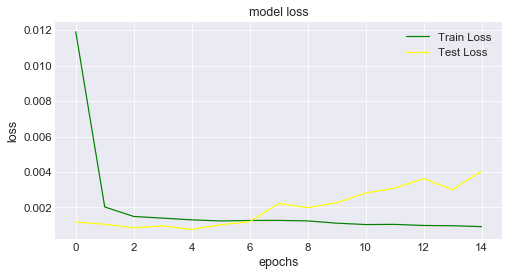

In [34]:
# plotting the figure for testign and training loss


plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')


plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

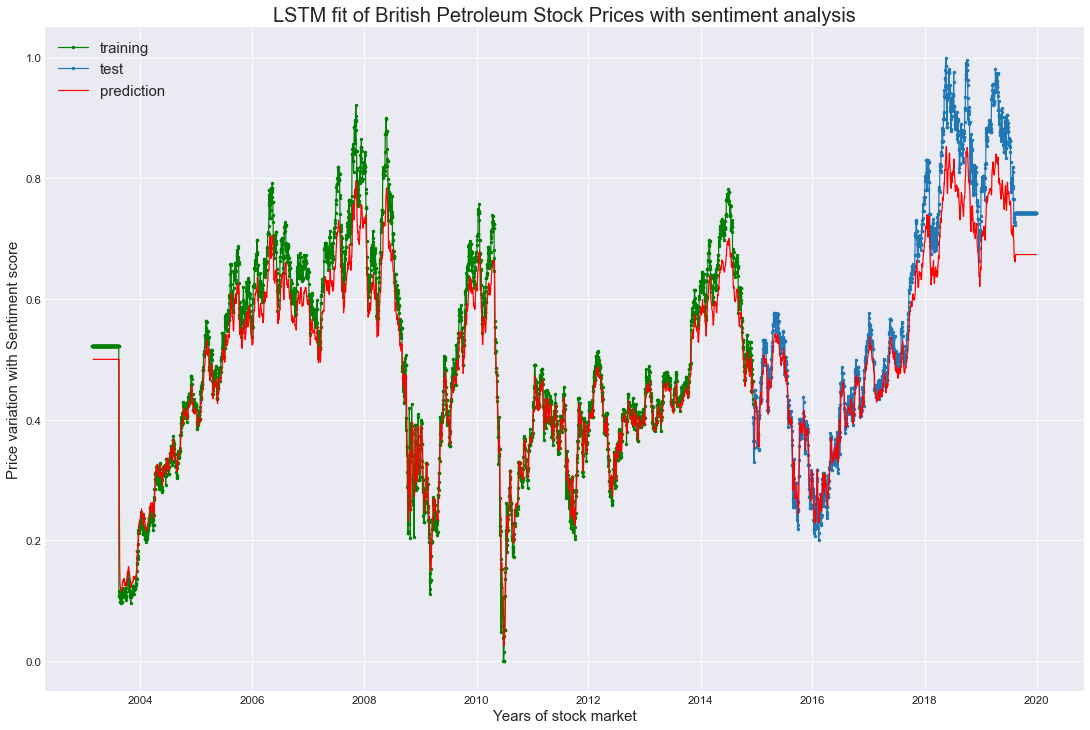

In [35]:
# final prediction based upon the british petroleum dataframe and sentiment dataframe will get the final prediction value


time_y_train = pd.DataFrame(data = train_y, index = finale[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = finale[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of British Petroleum Stock Prices with sentiment analysis",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('Price variation with Sentiment score', size=15)
plt.xlabel('Years of stock market', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();